In [1]:
import numpy as np
import XNLdyn
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

%matplotlib notebook

In [2]:
import warnings
warnings.filterwarnings('default')

In [3]:

## Set up the problem
PAR = XNLdyn.XNLpars()

N_local_fluences_to_calculate = 30
N_pulse_energies = 20
Nsteps_r = 100

pulse_energy_J = 1e-13# J

PAR.I0_i =  [0.5* XNLdyn.photons_per_J(PAR.E_i_abs[0])*pulse_energy_J,
             2*XNLdyn.photons_per_J(PAR.E_i_abs[1])*pulse_energy_J,
             2*XNLdyn.photons_per_J(PAR.E_i_abs[1])*pulse_energy_J,
             2*XNLdyn.photons_per_J(PAR.E_i_abs[1])*pulse_energy_J]

PAR.N_photens = 4
PAR.t0_i       = [-10,10, 20,30]   # Arrival time on time-axis / fs
PAR.tdur_sig_i = [10,10,15,10]  # Rms pulse duration / fs
PAR.E_i_abs    = [857,853,851,848] # Photon Energies of incident pulses / eV
PAR.lambda_res_Ei = (10,10,10,10)

print(*zip(PAR.E_i_abs,PAR.I0_i))


(857, 363.724305038506) (853, 1473.7919892469336) (851, 1473.7919892469336) (848, 1473.7919892469336)


In [4]:
sim = XNLdyn.XNLsim(PAR, DEBUG=False, load_tables = False)

sim.par.I0_i

Starting to generate lookup tables for T between 301.0 to 1000300.0 and Ef between -31.6 and 31.6
Lookup tables generated.
Saving at ./fermi_lookup_table.npz


[363.724305038506, 1473.7919892469336, 1473.7919892469336, 1473.7919892469336]

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:705: UserWarning: Number of holes got critically low for computational accuracy.
  warnings.warn(f'Number of holes got critically low for computational accuracy.')


<IPython.core.display.Javascript object>


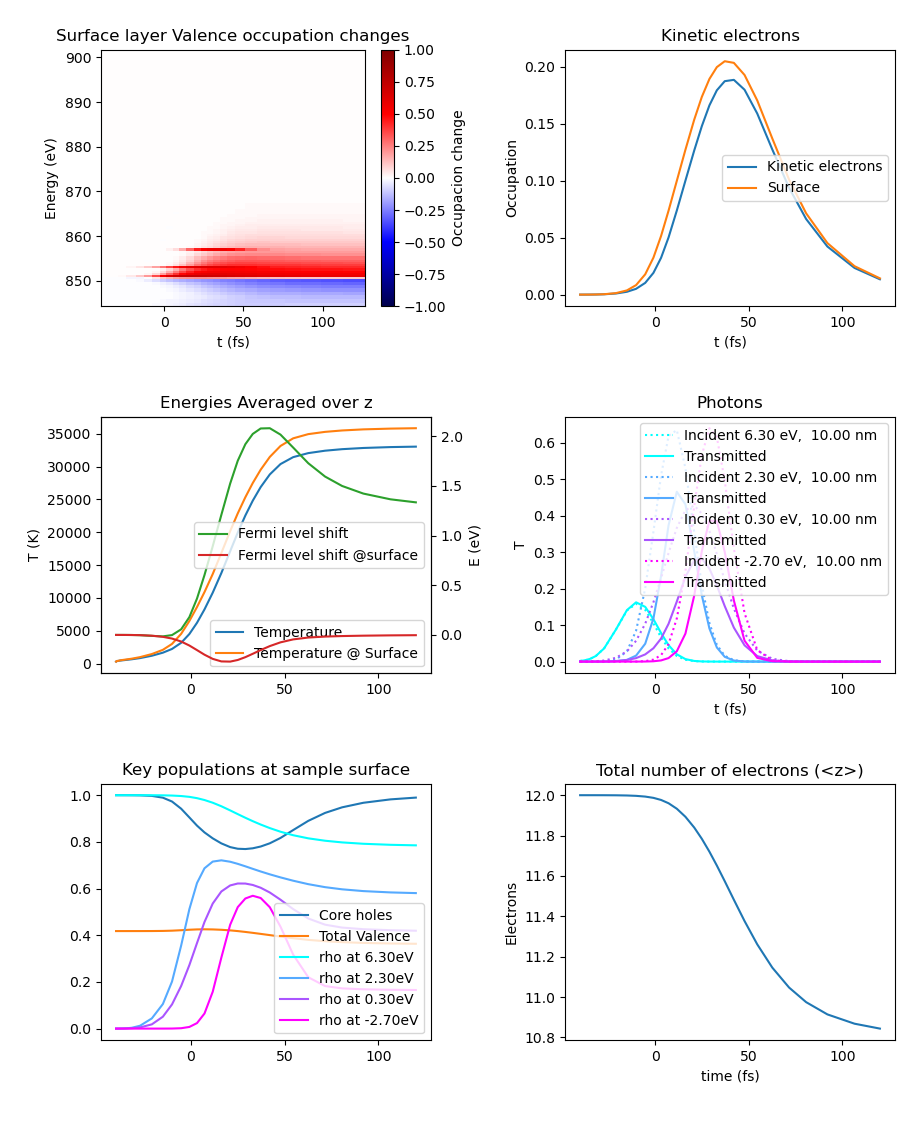

Transmission:  [105.85378717  62.71879451  53.7407244   51.66548832]  %
CPU times: user 30.4 s, sys: 259 ms, total: 30.6 s
Wall time: 30.4 s


In [5]:
%%time
sim_options = dict(t_span=[-40, 120],method='RK45', rtol=1e-3, atol=1e-8, plot = True, return_full_solution = True)

incident, transmitted, sol = sim.run(**sim_options)

print('Transmission: ', 100 * transmitted/incident, ' %')


In [ ]:
plt.figure()
plt.pcolormesh(sol.t, PAR.E_j +PAR.E_f,
               (sol.rho_j[0]-np.outer(PAR.rho_j_0,np.ones(sol.t.shape)))/np.outer(PAR.m_j,np.ones(sol.t.shape)),
               cmap = plt.cm.seismic, vmin = -1, vmax = 1, shading = 'nearest')#
plt.colorbar(label = 'Occupacion change (K)')
plt.xlabel('t (fs)')
plt.ylabel('Energy (eV)')
plt.title('Surface layer Valence occupation changes')
plt.ylim(None, 870)

<IPython.core.display.Javascript object>


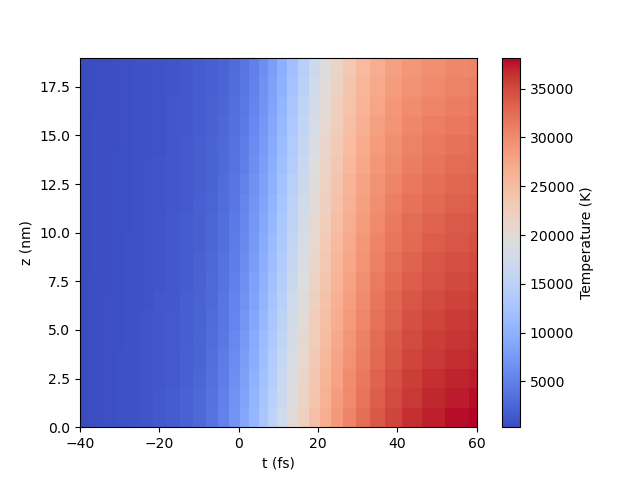

/tmp/ipykernel_126434/160184166.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, sol.temperatures.T, cmap = plt.cm.coolwarm)


Text(0, 0.5, 'z (nm)')

In [8]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, sol.temperatures.T, cmap = plt.cm.coolwarm)
plt.colorbar(label = 'Temperature (K)')
plt.xlabel('t (fs)')
plt.ylabel('z (nm)')

<IPython.core.display.Javascript object>


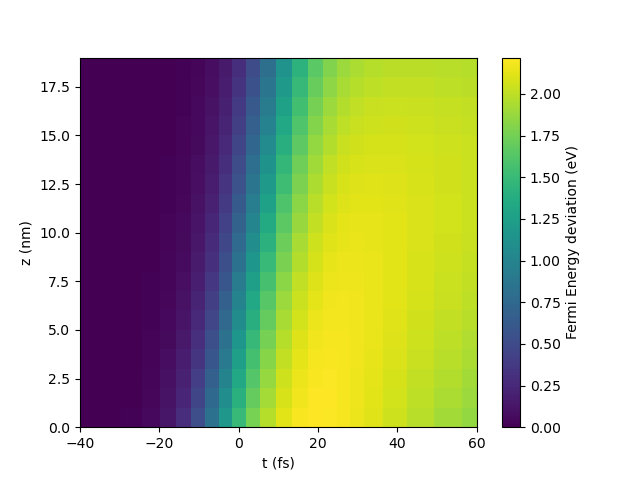

/tmp/ipykernel_119368/203480434.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, sol.fermi_energies.T)


Text(0, 0.5, 'z (nm)')

In [15]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, sol.fermi_energies.T)
plt.colorbar(label = 'Fermi Energy deviation (eV)')
plt.xlabel('t (fs)')
plt.ylabel('z (nm)')

<IPython.core.display.Javascript object>


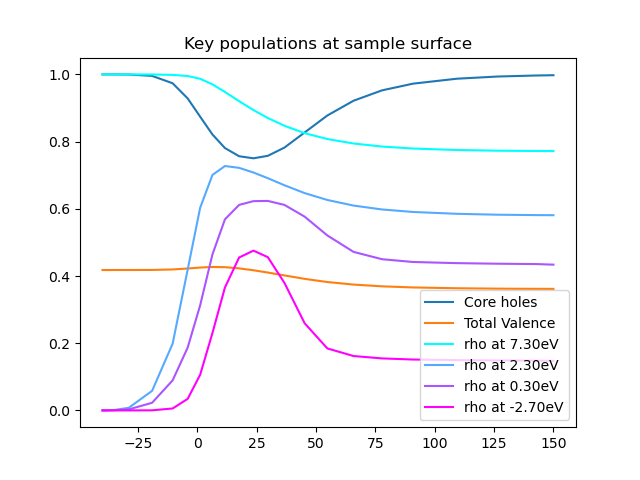

In [10]:
plt.figure()
plt.title('Key populations at sample surface')
plt.plot(sol.t,sol.core[0]/PAR.M_core, label = 'Core holes')
plt.plot(sol.t,(sol.R_VB[0])/PAR.M_VB, label = 'Total Valence')
cols = plt.cm.cool(np.linspace(0,1,PAR.N_photens))
for iE,E in enumerate(PAR.E_i):
    plt.plot(sol.t,sol.rho_j[0,PAR.resonant,:][iE].T/PAR.m_j[PAR.resonant][iE],c = cols[iE], label = f'rho at {E:.2f}eV')
plt.legend()


<IPython.core.display.Javascript object>


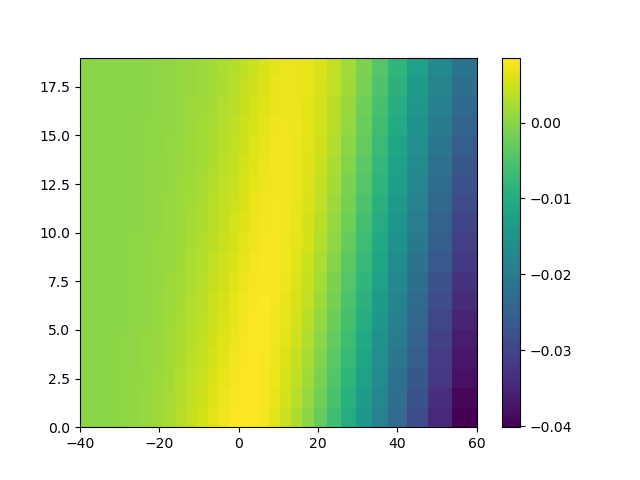

/tmp/ipykernel_121456/52012410.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, (sol.R_VB-PAR.R_VB_0)/PAR.M_VB)


In [34]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, (sol.R_VB-PAR.R_VB_0)/PAR.M_VB)
plt.colorbar()

In [21]:
sol.t.shape

(40,)

In [77]:
def make_valence_energy_axis(self, N_j: int, min=-6, finemax=10, max=50):
        """
        Creates an energy axis for the valence band, namely
            self.E_j
        and its edgepoints
            self.enax_j_edges
        Energies are relative to the fermi-level. 3/4 of all points fall into the range (min, finemax)
        Makes sure that the energies E_i correspond to a point in E_j and
        drops the closest points to keep the number N_j.
        :param N_j:
        :param min:
        :param finemax:
        :param max:
        :return:
        """
        N_j_fine = int(N_j * 3 / 4)
        N_j_coarse = int(N_j - N_j_fine)

        def fill_biggest_gap(pointlist):
            """
            This function takes a list of points and appends a point in the middle of the biggest gap
            """
            pointlist = np.array(np.sort(pointlist))
            gaps = pointlist[1:]-pointlist[:-1]
            biggest_gap_index = np.argsort(gaps)[-1]
            biggest_gap = gaps[biggest_gap_index]
            list_before = pointlist[:biggest_gap_index+1]
            new_value = pointlist[biggest_gap_index] + 0.5*biggest_gap
            list_after = pointlist[biggest_gap_index+1:]
            return np.concatenate((list_before, [new_value,], list_after))
        
        # The energies E_i and 0 must be in the axis
        enax_j_fine = [min, 0, finemax]+list(self.E_i[self.E_i<=finemax])
        # Fill up the gaps
        while len(enax_j_fine)<N_j_fine:
            enax_j_fine = fill_biggest_gap(enax_j_fine)
        
        dE = np.mean(enax_j_fine[1:]-enax_j_fine[:-1])
        #The same for the coarse part
        enax_j_coarse = [finemax+dE, max]+list(self.E_i[self.E_i>finemax])
        while len(enax_j_coarse)<N_j_coarse:
            enax_j_coarse = fill_biggest_gap(enax_j_coarse)
            
        enax_j = np.concatenate((enax_j_fine, enax_j_coarse))

        if not len(enax_j) == N_j:
            warnings.warn(
                'Energy Axis turned out longer or shorter than planned. What went wrong?')
            self.N_j = len(enax_j)
            
        def edgepoints(middles):
            """ Opposite of midpoints """
            edges = np.empty(middles.shape[0] + 1)
            edges[1:-1] = (middles[1:] + middles[:-1]) / 2
            edges[0] = middles[0] - (middles[1] - middles[0]) / 2
            edges[-1] = middles[-1] + (middles[-1] - middles[-2]) / 2
            return edges

        return enax_j, edgepoints(enax_j)

In [55]:
sim.plot_derivatives?

<IPython.core.display.Javascript object>


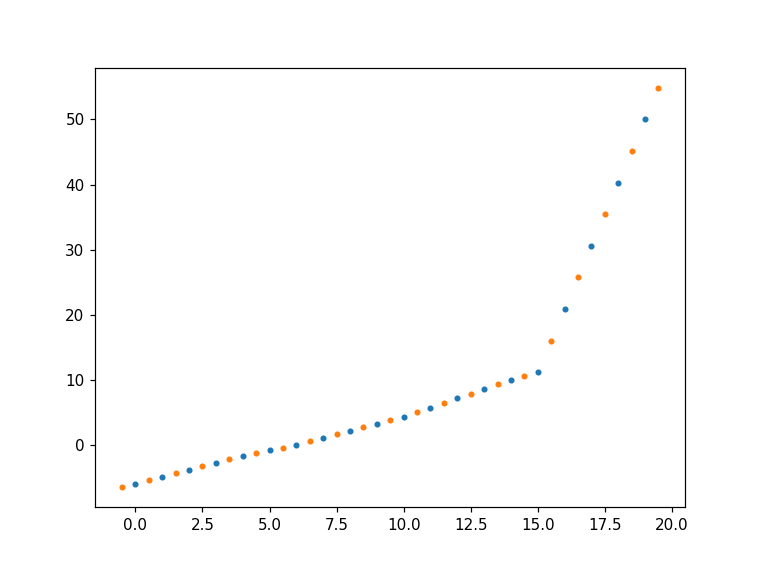

In [82]:
enax, enax_edges = make_valence_energy_axis(PAR, 20, min=-6, finemax=10, max=50)
plt.figure()
plt.plot(np.arange(len(enax)),enax,'.')
plt.plot(np.arange(len(enax_edges))-0.5,enax_edges,'.')